In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

import importlib
from pathlib import Path

import sys

sys.path.append(str(Path.home() / "Projects" / "MaxEnt" / "Code"))

import Basic_functions as bf
import Synthetic_data as sd
import R_roughness as rr

importlib.reload(bf)
importlib.reload(sd)
importlib.reload(rr)

import D2_cube_with_noise_with_roughness_normalize as dcwwn

importlib.reload(dcwwn)

<module 'D2_cube_with_noise_with_roughness_normalize' from '/Users/xunan/Projects/MaxEnt/Code/D2_cube_with_noise_with_roughness_normalize.py'>

In [2]:
img  = nib.load("~/Projects/MaxEnt/Data/MultiTE_DirAvg/REDIM_diravg.nii.gz")
mask = nib.load("~/Projects/MaxEnt/Data/MultiTE_DirAvg/B0_WMPARC.nii.gz")

signal = img.get_fdata()

# signal = np.flip(img.get_fdata(), axis = 0) # flip it such that it matches the indices in MRView
# seg = np.flip(mask.get_fdata(), axis = 0)

print(signal.shape)

(96, 96, 54, 30)


In [3]:
bvals = np.loadtxt("/Users/xunan/Projects/MaxEnt/Data/MultiTE_DirAvg/bvals.txt") / 1000 # in unit ms/{\mu m} ^2
TEs = np.loadtxt("/Users/xunan/Projects/MaxEnt/Data/MultiTE_DirAvg/TEs.txt")/1000  # in unit s
qs = np.column_stack((bvals, TEs))

In [4]:
signal_norm = signal[:,:,:,qs[:,0]!=0] / np.repeat(signal[:,:,:,qs[:,0]==0], 5, axis = -1)
qs_norm = np.delete(qs, qs[:, 0] == 0, axis = 0)

In [5]:
Sqs = signal_norm[44, 38, 43, :].reshape((-1, qs_norm.shape[0]), order = 'C')

In [6]:
theta1 = np.linspace(0, 3, 100)
theta2 = np.linspace(0, 100, 100)
thetas, weights = bf.Cartesian(theta1, theta2)
R = np.zeros((25, 25))

In [7]:
std_vector = 0.02*np.ones(len(Sqs))
diff_matrix = np.empty((len(Sqs), 25))

for i in range(len(Sqs)):

    Sqs_single = Sqs[i,:]

    lambdas_single, f_single, obj_single = dcwwn.Newton_Armijo(  qs_norm, thetas, weights, Sqs_single, sigma = std_vector[i], 
                                    R = np.zeros((25, 25)), f0 = None, normalize = True, # est.ravel(order = 'F')[None, :]/np.dot(est.ravel(order = 'F'), weights)
                                    Lambdas = None,
                                    ridge = False, log_max = -2, log_min = -4, n_last = 10, 
                                    use_cg = False, pc_method = 'jacobi', cg_rtol = 1e-8, cg_maxiter = 1000, 
                                    beta=0.5, c=1e-4, tol=1e-10, epsilon = 1e-10, max_iter=200)

    Sqs_single_recovered = bf.get_Sqs(bf.kernel(qs_norm, thetas), weights, f_single.ravel())

    # plt.plot(Sqs_single.ravel(), '*', color = 'red')
    # plt.plot(Sqs_single_recovered.ravel(), '.', color = 'blue')

    diff = Sqs_single - Sqs_single_recovered.ravel()
    std = np.std(diff)

    std_vector[i] = std
    diff_matrix[i] = diff



Newton Armijo maximum iterations reached: 200


In [8]:
sigma = np.mean(std_vector)
print("estimation of sigma is:", np.round(sigma, 5))

estimation of sigma is: 0.0633


In [21]:
lambdas, f_hat, obj_history = dcwwn.admm(   qs_norm, thetas, weights, Sqs, sigma = 0.01,
                                            R = R*0, f0 = None, normalize = True,
                                            Lambdas = None, rho = 1e-1,
                                            beta = 0.5, c = 1e-4, tol = 1e-6, epsilon = 1e-8, max_iter = 10,
                                            ridge = False, log_max = 0, log_min = -10, n_last = 10,
                                            use_cg = True, pc_method = 'chol', cg_rtol = 1e-10, cg_maxiter = 2000,
                                            admm_tol = 1e-10, admm_max_iter = 1000, dynamic_rho = True)


2.1464925970905897e-12 1.6529418750291383e-11



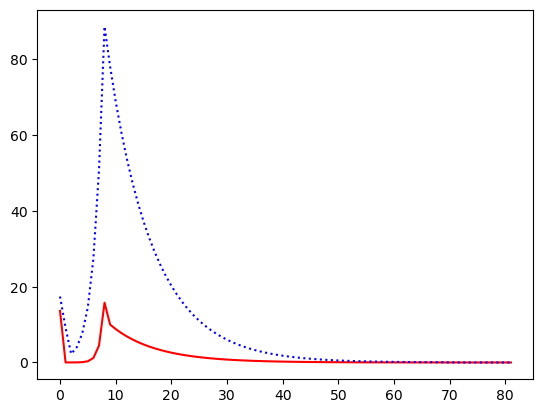

In [22]:
plt.plot(obj_history[1][:], '-', color = 'red', label = 'primal')
plt.plot(obj_history[2][:], ':', color = 'blue', label = 'dual')
# plt.ylim((0, 1200))
print(obj_history[1][-1], obj_history[2][-1])
print()

In [23]:
Sqs_recovered = Sqs.copy()
for i in range(len(Sqs)):
    Sqs_recovered[i, :] = bf.get_Sqs(bf.kernel(qs_norm, thetas), weights, f_hat[i].ravel())

std_recovered = np.std(Sqs - Sqs_recovered, axis = 1)
print(np.mean(std_recovered))

0.017442681953572556


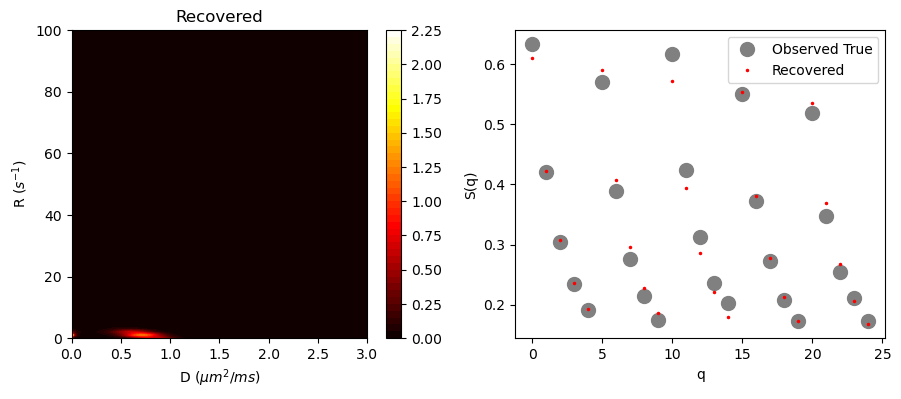

In [24]:
bf.contourf_compare(theta1, theta2, f_hat = f_hat.ravel(), qs = qs_norm, Sqs = Sqs.ravel(), f_true = None, savepath = None)